In [89]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [90]:
def scrape_salaries(position, year=2024):
    url_map = {
        "QB": f"https://overthecap.com/position/quarterback/{year}",
        "RB": f"https://overthecap.com/position/running-back/{year}",
        "WR": f"https://overthecap.com/position/wide-receiver/{year}"
    }
    url = url_map[position]
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    table = soup.find("table")
    rows = table.find("tbody").find_all("tr")

    data = []
    for row in rows[:35]:  # Only take top 35
        cols = row.find_all("td")
        if len(cols) >= 3:
            player = cols[0].get_text(strip=True)
            team = cols[1].get_text(strip=True)
            salary = float(cols[2].get_text(strip=True).replace("$", "").replace(",", ""))
            data.append([player, team, position, salary])
    return pd.DataFrame(data, columns=["Player", "Team", "Position", "Salary"])

In [91]:
# Collect salary data
qb_salary = scrape_salaries("QB")
rb_salary = scrape_salaries("RB")
wr_salary = scrape_salaries("WR")
salary_df = pd.concat([qb_salary, rb_salary, wr_salary], ignore_index=True)

In [92]:
# 2. Scrape Performance Stats
def scrape_qb_stats():
    url = "https://www.pro-football-reference.com/years/2024/passing.htm"
    df = pd.read_html(url)[0]
    df = df[df['Player'] != 'Player']
    df = df[['Player', 'Team', 'Yds', 'TD', 'Cmp%']]
    df.columns = ['Player', 'Team', 'Passing_Yards', 'Pass_TDs', 'Completion_Pct']
    return df

def scrape_rb_stats():
    url = "https://www.pro-football-reference.com/years/2024/rushing.htm"
    df = pd.read_html(url, header=1)[0]
    df = df[df["Player"] != "Player"]
    df = df[["Player", "Team", "Yds", "TD", "Y/A"]]
    df.columns = ["Player", "Team", "Rush_Yards", "Rush_TDs", "Yards_per_Carry"]
    df["Rush_Yards"] = pd.to_numeric(df["Rush_Yards"], errors="coerce")
    df["Rush_TDs"] = pd.to_numeric(df["Rush_TDs"], errors="coerce")
    df["Yards_per_Carry"] = pd.to_numeric(df["Yards_per_Carry"], errors="coerce")
    return df

def scrape_wr_stats():
    url = "https://www.pro-football-reference.com/years/2024/receiving.htm"
    df = pd.read_html(url, header=1)[0]
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    df = df[df["Player"] != "Player"]
    df = df[["Player", "Team", "Yds", "TD", "Y/R"]]
    df.columns = ["Player", "Team", "Receiving_Yards", "Receiving_TDs", "Yards_per_Catch"]
    df["Receiving_Yards"] = pd.to_numeric(df["Receiving_Yards"], errors="coerce")
    df["Receiving_TDs"] = pd.to_numeric(df["Receiving_TDs"], errors="coerce")
    df["Yards_per_Catch"] = pd.to_numeric(df["Yards_per_Catch"], errors="coerce")
    return df

qb_stats = scrape_qb_stats()
rb_stats = scrape_rb_stats()
wr_stats = scrape_wr_stats()

In [93]:
# 3. Merge Salary with Stats
qb_merged = pd.merge(qb_salary, qb_stats, on='Player', how='left')
rb_merged = pd.merge(rb_salary, rb_stats, on='Player', how='left')
wr_merged = pd.merge(wr_salary, wr_stats, on='Player', how='left')
combined_df = pd.concat([qb_merged, rb_merged, wr_merged], ignore_index=True)

In [94]:
# 4. Value Index Calculation
combined_df["Salary_M"] = combined_df["Salary"] / 1_000_000
combined_df["Yards"] = (
    combined_df["Passing_Yards"].fillna(0) +
    combined_df["Rush_Yards"].fillna(0) +
    combined_df["Receiving_Yards"].fillna(0)
)
combined_df["Value_Index"] = combined_df["Yards"] / combined_df["Salary_M"]


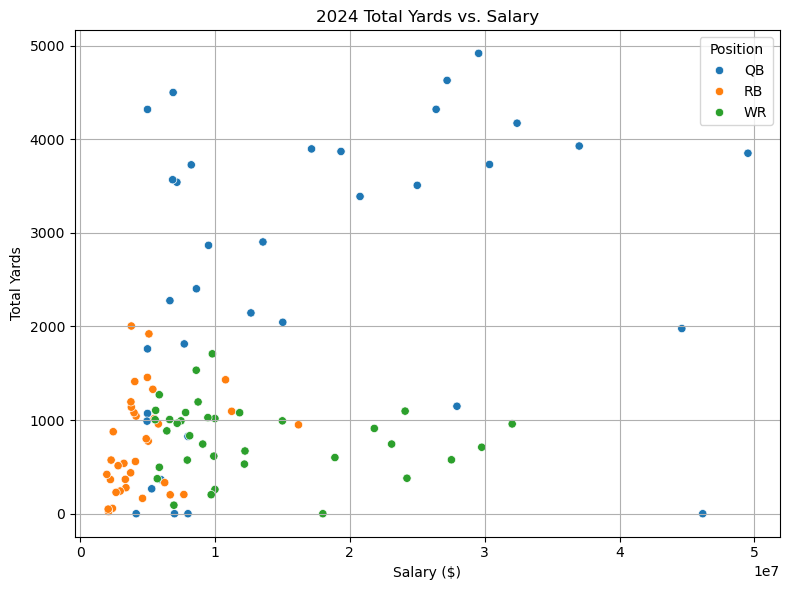

In [95]:
# Scatter Plot: Salary vs. Total Yards
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x="Salary", y="Yards", hue="Position")
plt.title("2024 Total Yards vs. Salary")
plt.xlabel("Salary ($)")
plt.ylabel("Total Yards")
plt.grid(True)
plt.tight_layout()
plt.show()

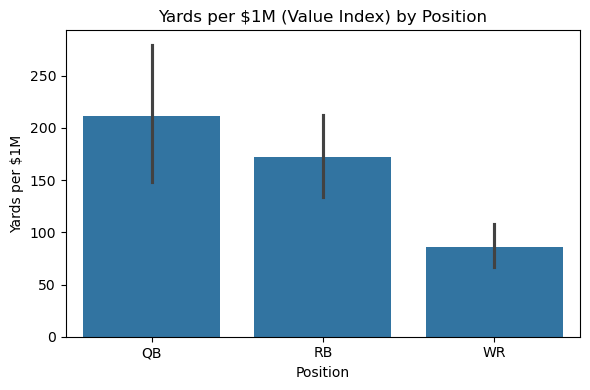

In [96]:
# Bar Chart: Average Value Index by Position
plt.figure(figsize=(6, 4))
sns.barplot(data=combined_df, x="Position", y="Value_Index", estimator="mean")
plt.title("Yards per $1M (Value Index) by Position")
plt.ylabel("Yards per $1M")
plt.tight_layout()
plt.show()

In [97]:
# Filter out missing or NaN values
qb_values = combined_df[(combined_df["Position"] == "QB") & (combined_df["Value_Index"].notna())]["Value_Index"]
rb_values = combined_df[(combined_df["Position"] == "RB") & (combined_df["Value_Index"].notna())]["Value_Index"]

# Perform Welch's t-test (does not assume equal variances)
t_stat, p_val = ttest_ind(qb_values, rb_values, equal_var=False)

# Print the results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 1.01
P-value: 0.3168


In [98]:
# Save the final combined data to an Excel file
combined_df.to_excel("NFL_2024_Salary_Performance.xlsx", index=False)